In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [13]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
#conn = engine.connect()

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)
#Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['station', 'measurement']

In [7]:
# Save references to each table
MeasurementClass = Base.classes.measurement
StationClass = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [54]:
# Just checking..
first_row_measure = session.query(MeasurementClass).first()
first_row_measure.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x19216419d30>,
 'date': '2010-01-01',
 'tobs': 65.0,
 'id': 1,
 'station': 'USC00519397',
 'prcp': 0.08}

In [47]:
first_row_station = session.query(StationClass).first()
first_row_station.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1921690f3b0>,
 'latitude': 21.2716,
 'id': 1,
 'elevation': 3.0,
 'longitude': -157.8168,
 'station': 'USC00519397',
 'name': 'WAIKIKI 717.2, HI US'}

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
# Thank you assist by @skhan3 (Saad LA from AskBCS!!)
recent_date = session.query(func.max(MeasurementClass.date)).first()
print(recent_date)

('2017-08-23',)


In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
# Calculate the date one year from the last date in data set.
prev_year = dt.date(2017, 8, 23) - dt.timedelta(days=365)
prev_year

datetime.date(2016, 8, 23)

In [ ]:
##EXPERIMENTING>>> Get the above query into a pandas DF.
#prcp_df = pd.read_sql(session.query(MeasurementClass.date,MeasurementClass.prcp).filter(MeasurementClass.date>=prev_year).all(),session.conn)

In [15]:
# Perform a query to retrieve the date and precipitation scores
precipitation_results=session.query(MeasurementClass.date,MeasurementClass.prcp).filter(MeasurementClass.date>=prev_year).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
prcp_df = pd.DataFrame(precipitation_results,columns=['date','precipitation'])
prcp_df

,date,precipitation
0,2016-08-23,0.00
1,2016-08-24,0.08
2,2016-08-25,0.08
3,2016-08-26,0.00
4,2016-08-27,0.00
...,...,...
2225,2017-08-19,0.09
2226,2017-08-20,NaN
2227,2017-08-21,0.56
2228,2017-08-22,0.50


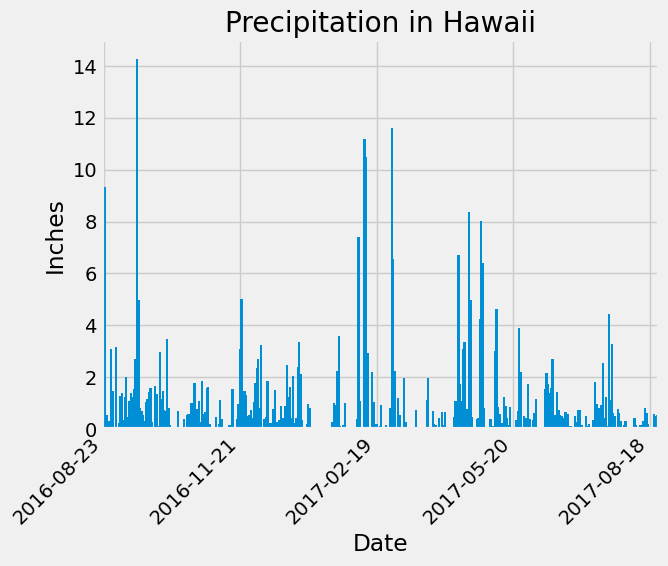

In [46]:
# Sort the dataframe by date
# convert to date
prcp_df['date'] = pd.to_datetime(prcp_df['date'])
sorted_df=prcp_df.sort_values(by='date', ascending=False)
daily_data=sorted_df.groupby(sorted_df['date'])['precipitation'].sum()

# Use Pandas Plotting with Matplotlib to plot the data
ax = daily_data.plot(x="date", y="precipitation", kind="bar", width = 1.5)
plt.title('Precipitation in Hawaii')
plt.xlabel('Date')
plt.ylabel('Inches')

xtick_positions = range(0, len(daily_data), 90)
xtick_labels = daily_data.index[xtick_positions].strftime('%Y-%m-%d')
ax.set_xticks(xtick_positions)
ax.set_xticklabels(xtick_labels, rotation=45, ha='right')

plt.show()


In [35]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_stats = prcp_df['precipitation'].describe()
summary_stats

count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: precipitation, dtype: float64

# Exploratory Station Analysis

In [48]:
# Design a query to calculate the total number of stations in the dataset
station_count = session.query(StationClass).count()
station_count

9

In [53]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.

# Query and count stations, ordering by count in descending order
station_counts = session.query(StationClass.station, func.count(StationClass.station)).\
group_by(StationClass.station).order_by(func.count(StationClass.station).desc()).all()

# Print the results
for station, count in station_counts:
    print(f"Station: {station}, Count: {count}")

Station: USC00519523, Count: 1
Station: USC00519397, Count: 1
Station: USC00519281, Count: 1
Station: USC00518838, Count: 1
Station: USC00517948, Count: 1
Station: USC00516128, Count: 1
Station: USC00514830, Count: 1
Station: USC00513117, Count: 1
Station: USC00511918, Count: 1


In [ ]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
#HINT USE JOIN

In [ ]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram


# Close Session

In [ ]:
# Close Session
session.close()